In [4]:
import os 
import sys
import albumentations as A
from tqdm.notebook import tqdm
from albumentations.pytorch.transforms import ToTensorV2
from timm import create_model
from src.utils import seed_everything
from src.dataset import FaceDataset
from configs.resnet18 import Config
from src.trainer import Trainer
from timm import create_model
import numpy as np
import torch
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def train_fn(cfg,path):
    seed_everything(cfg.seed)
    # Get Model
    model   = create_model(cfg.arch,cfg.pretrained, num_classes=1)
    # Set Trainer
    trainer = Trainer(config = cfg,
                      model  = model)
    
    trainer.fit(path)

## 1. Train an Upside down detector

In [7]:
cfg  = Config()
path = 'dataset/celebrity-256/custom'

In [3]:
train_fn(cfg,path)

wandb: Currently logged in as: williamberrios (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.13 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


================= EPOCH: 1 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

/opt/conda/envs/rapids/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (-inf --> 0.8285). Saving model!
================= EPOCH: 2 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.8285 --> 0.9476666666666667). Saving model!
================= EPOCH: 3 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9476666666666667 --> 0.9826666666666667). Saving model!
================= EPOCH: 4 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9826666666666667 --> 0.9916666666666667). Saving model!
================= EPOCH: 5 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9916666666666667 --> 0.9945). Saving model!
================= EPOCH: 6 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9945 --> 0.9958333333333333). Saving model!
================= EPOCH: 7 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9958333333333333 --> 0.9961666666666666). Saving model!
================= EPOCH: 8 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9961666666666666 --> 0.9963333333333333). Saving model!
================= EPOCH: 9 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9963333333333333 --> 0.9971666666666666). Saving model!
================= EPOCH: 10 =================
**** Training **** 


  0%|          | 0/94 [00:00<?, ?it/s]

**** Validation ****


  0%|          | 0/24 [00:00<?, ?it/s]

**** Metrics ****
Validation score improved (0.9971666666666666 --> 0.9976666666666667). Saving model!
Didn't meet early stopping


## 2. Visualizing Predictions

In [51]:
def predict(cfg,model,loader):
    final_preds  = []
    final_target = []
    with torch.no_grad():
        tk0 = tqdm(loader, total=len(loader))
        for b_idx, data in enumerate(tk0):
            for key,value in data.items():
                data[key] = value.to(cfg.device)
            preds   = model(data[cfg.feature_name])
            preds   = torch.sigmoid(preds).cpu().numpy()
            final_preds.append((preds>0.5)*1)
            final_target.append(data[cfg.target_name].cpu().numpy())
    return np.vstack(final_preds).ravel(),np.hstack(final_target)

def gallery(array, ncols=3):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array(dataset,dataset_rgb,indexes,init = 0,n = 20):
    img_list = []
    for k in range(init,init+n):
        try:
            input_tensor = dataset[indexes[k]]['image'].unsqueeze(0)
            rgb_image    = dataset_rgb[indexes[k]]['image']
            target       = targets[indexes[k]]
            pred        = preds[indexes[k]]
            cam = GradCAMPlusPlus(model=model, target_layers=target_layer, use_cuda=True)
            grayscale_cam = cam(input_tensor=input_tensor, targets = None)
            img = show_cam_on_image(rgb_image/255,grayscale_cam[0])
            img_list.append(img)
        except:
            pass
    return np.array(img_list)

In [52]:
# 1. Load the model
checkpoint = torch.load("SavedModels/Fatima-Fellowship/resnet18/model_label.pt",map_location = 'cpu')
model      = create_model(cfg.arch,pretrained = False,num_classes = 1)
model.load_state_dict(checkpoint,strict = True)
model.to(cfg.device)
model.eval()
target_layer = [model.layer4[-1]]

# 2. Create test dataloader
dataset_rgb = FaceDataset(path,'test',None)
dataset = FaceDataset(path,'test',cfg.transformations['test'])
loader  = torch.utils.data.DataLoader(dataset,
                                      batch_size  = cfg.batch_size,
                                      num_workers = cfg.num_workers,
                                      shuffle     = False,
                                      pin_memory  = True)


In [53]:
preds,targets = predict(cfg,model,loader)
indexes = preds==targets
indexes_bad  = [i for i, x in enumerate(indexes) if x==False]
indexes_good = [i for i, x in enumerate(indexes) if x]

  0%|          | 0/24 [00:00<?, ?it/s]

## 2.1 Correct Predictions - Up

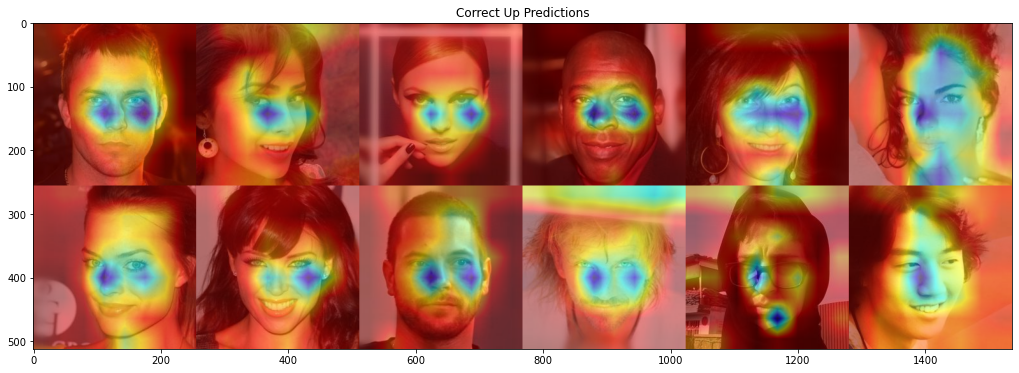

In [54]:
array = make_array(dataset,dataset_rgb,indexes_good,n=12)
result = gallery(array,ncols = 6)
plt.figure(figsize=(20, 6))
plt.title("Correct Up Predictions")
plt.imshow(result)
plt.show()

## 2.2 Correct Predictions - Down

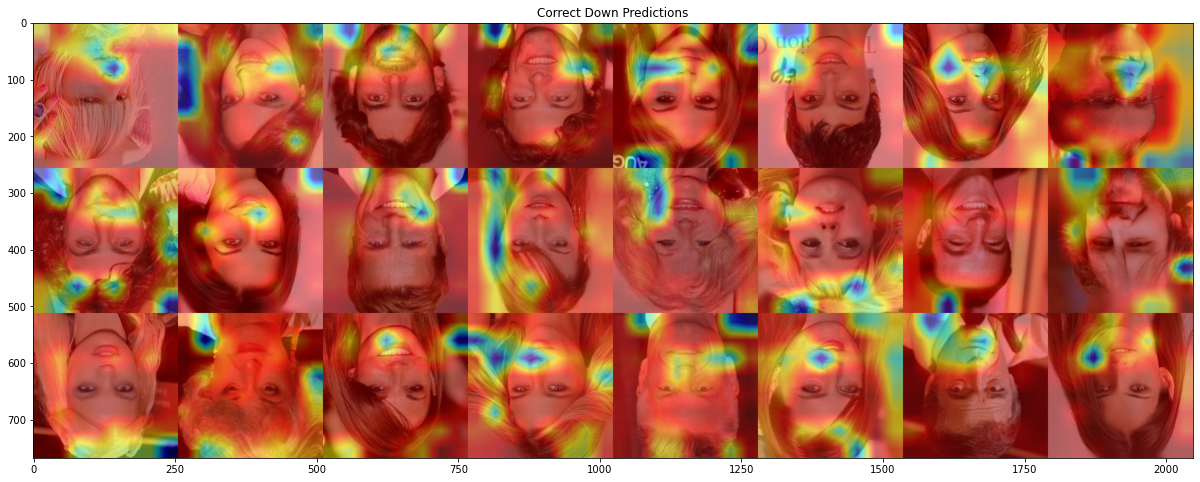

In [55]:
array = make_array(dataset,dataset_rgb,indexes_good,init =4800, n=24)
result = gallery(array,ncols = 8)
plt.figure(figsize=(50, 8))
plt.title("Correct Down Predictions")
plt.imshow(result)
plt.show()

## 2.1 Error Analisys with GradCAM++

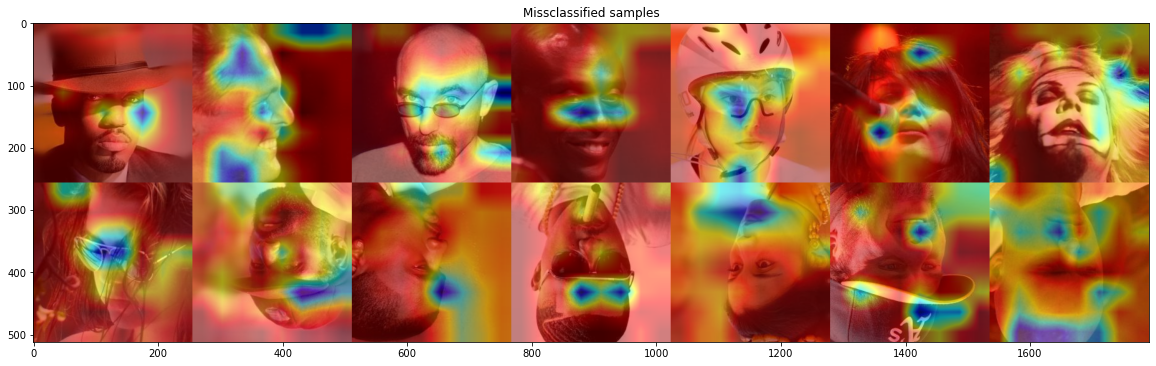

In [56]:
array = make_array(dataset,dataset_rgb,indexes_bad,n=14)
result = gallery(array,ncols = 7)
plt.figure(figsize=(20, 8))
plt.imshow(result)
plt.title('Missclassified samples')
plt.show()

### Comments
We can use GradCam as an interpretability method for our network.
+ We can see that "Up" predictions are mostly detecting patterns in the face like eyes or nose positions.
+ On the other side, "Down" predictions seem to rely on external characteristics to the face. For example:
    + Some images seem to rely on the shoulder appearing in the picture.
    + Others seem to rely on the position of the hair (if the hair is at the downside of the image, the classifier might predict that the image is in the "Down" position)

### Improvements
+ We can verify that our model is predicting very well for images appearing in the celebA-HQ dataset (99% acc). However, **It would be also relevant to test the model on out of distribution images (e.g images taken with our cellphones).**
+ In addition, we see that some images that are correctly predicted as "Down" position might rely on the presence of shoulders. **In this case, It would be a good idea to extract only the faces (using an object detector model) in order to force our network to not concentrate on this pattern of shoulders.**
+ Finally, looking at the misclassified examples, we can appreciate that it might fail in cases in which people have glasses, hats, or any other object (e.g microphone). **In this case, adding more data with these characteristics can improve the accuracy of our model.**